In [20]:
import pandas as pd
import warnings
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.functions import *
sns.set(rc={'figure.figsize':(10,8), 'font.size': 1.3})
import re

In [21]:
def read_df():
    df = pd.read_csv('Results-moddataset\datamod.csv')
    df = df.drop(columns=['Diag_TRS_Eje1ComunNomenclatura_9', 'Diag_TRS_Eje1Previo-Subsecuente_9', 'Diag_TRS_Eje1CodigoCompuesto_9', 'Diag_TRS_Eje1Codigo_9', 'Diag_TRS_Eje1Descripcion_9', 'Diag_TRS_Eje1ComunNomenclatura_10', 'Diag_TRS_Eje1Previo-Subsecuente_10', 'Diag_TRS_Eje1CodigoCompuesto_10', 'Diag_TRS_Eje1Codigo_10', 'Diag_TRS_Eje1Descripcion_10'] )
    return df

In [22]:
def list_to_psm():
    list = ['FolioId','Migracion', 'Edad', 'Sexo', 'EstadoCivil', 'Escolaridad' , 'NivSocioEco', 'Ocupacion', 'ComunidadIndigena', 'DiscapacidadPerceptual' ]
    return list

In [23]:
def list_to_exclude(df):
    list_exclude = []
    for col in df.columns:
        if col.startswith('Trast') or col.startswith('Diag'):
            list_exclude.append(col)
    return list_exclude


In [24]:
def new_dataset(df):
    df = df[list_to_psm() + list_to_exclude(df)]
    return df

In [25]:
def main():
    df = read_df()
    list_exclude = list_to_exclude(df)
    df = new_dataset(df)
    return df, list_exclude

In [26]:
warnings.filterwarnings("ignore")
df, list_exclude = main()

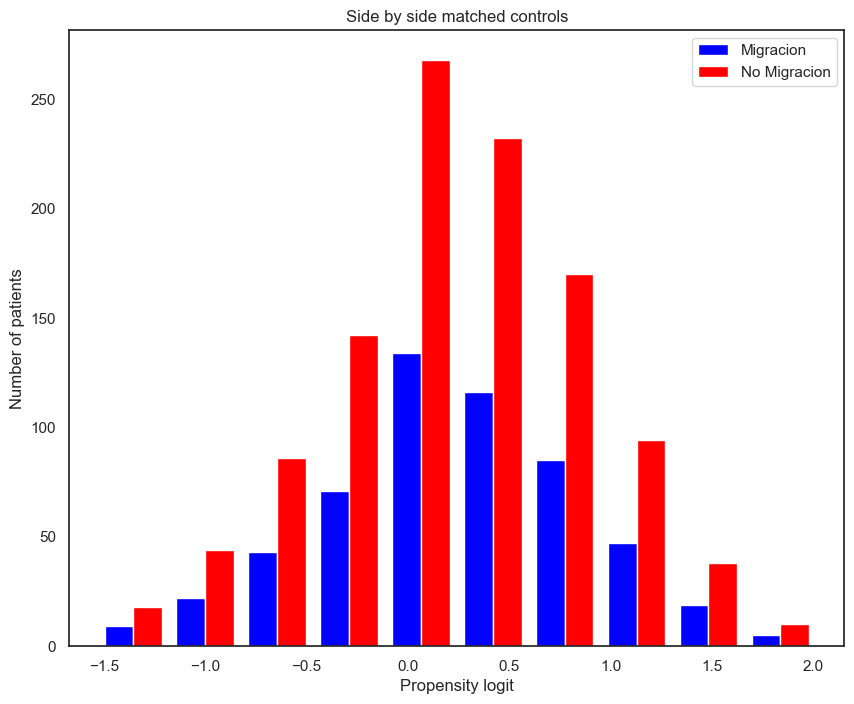

In [27]:
psm = PsmPy(df, treatment= 'Migracion', indx= 'FolioId', exclude = list_exclude)
psm.logistic_ps()
#psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None, drop_unmatched=True) match 1:1
psm.knn_matched_12n(matcher='propensity_logit', how_many= 2) # match 1:N
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of patients', Xlabel='Propensity logit', names = ['Migracion', 'No Migracion'], colors = ['blue', 'red'], save=True)
psm.matched_ids.to_csv('Results-propensityscore\matched_ids.csv', index=False)

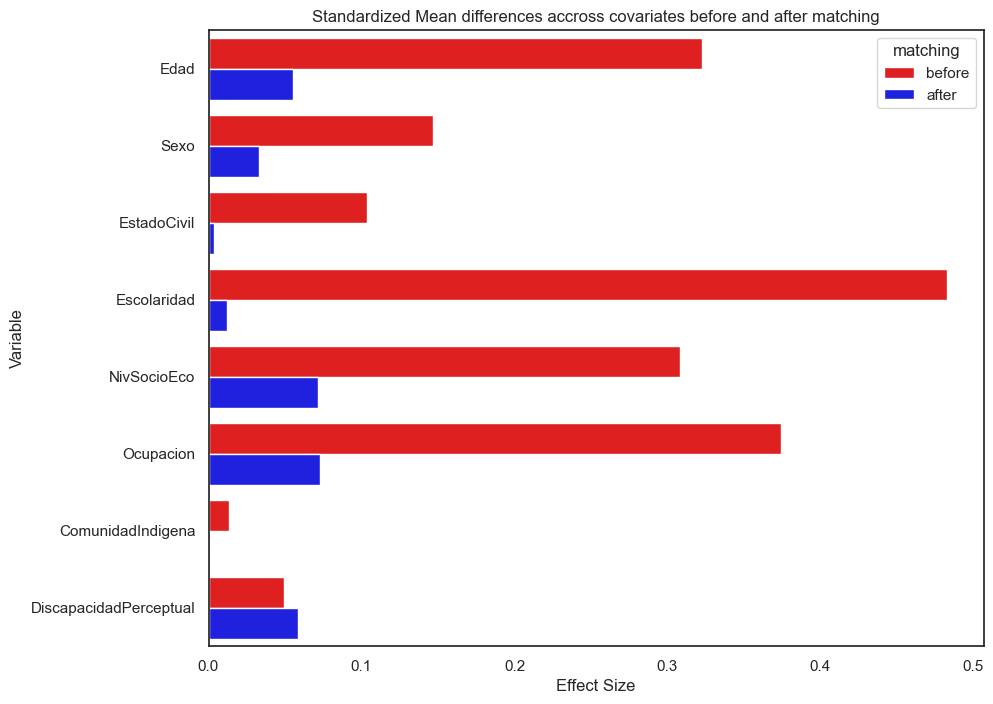

In [28]:
psm.effect_size_plot(title='Standardized Mean differences accross covariates before and after matching', before_color='Red', after_color='Blue', save=True)
psm.effect_size.to_csv('Results-propensityscore\effect_size.csv', index=False)

In [29]:
def gen_newdf (df_matched_ids, df_dataset):
    """
    Generate a new DataFrame with the matched ids
    param: df_matched_ids, df_DataFrame
    return: df_DataFrame
    """
    df_matched = df_dataset[df_dataset['FolioId'].isin(df_matched_ids['FolioId'])]
    df_matched = pd.concat([df_matched, df_dataset[df_dataset['FolioId'].isin(df_matched_ids['largerclass_0group'])]], axis= False)
    df_matched = pd.concat([df_matched, df_dataset[df_dataset['FolioId'].isin(df_matched_ids['largerclass_1group'])]], axis= False)
    return df_matched


In [30]:
new_df = gen_newdf(psm.matched_ids, df)
new_df.to_csv('Results-propensityscore\matched_dataset.csv', index=False)